In [65]:
import json
import os
from io import StringIO

import numpy as np
import pandas as pd

Reading the raw dataset.

In [66]:
directory = "../raw/article_bias_prediction"
data = []
for i, filename in enumerate(os.listdir(directory)):
    filepath = os.path.join(directory, filename)
    with open(filepath, "r") as file:
        data.append(json.load(file))

df = pd.DataFrame(data)
df

,topic,source,bias,url,title,date,authors,content,content_original,source_url,bias_text,ID
0,justice_department,Fox Online News,2,http://www.foxnews.com/politics/2014/01/14/tea...,Sham? DOJ under fire amid claims IRS probe unl...,2014-01-14,,The Justice Department is facing mounting crit...,The Justice Department is facing mounting crit...,www.foxnews.com,right,JeZWeFJcWcdY179c
1,immigration,USA TODAY,1,http://www.usatoday.com/story/news/politics/20...,Senators aiming for 70 votes on immigration bill,2013-04-25,Alan Gomez,Schumer says security enhancements in bill `` ...,"Sen. Charles Schumer, D-N.Y., and Sen. John Mc...",www.usatoday.com,center,ZvUXHGCmSccFtz6C
2,us_house,USA TODAY,1,https://www.usatoday.com/story/news/politics/2...,"House passes tax bill, again and with fixes, s...",2017-12-20,,"WASHINGTON — In an unusual do-over vote , the ...",Deirdre Shesgreen\n\nUSA TODAY\n\nWASHINGTON —...,www.usatoday.com,center,8VrBFh087O1j9sUk
3,elections,Townhall,2,https://townhall.com/notebook/bethbaumann/2018...,Sen. Dianne Feinstein Fails to Receive Califor...,2018-02-25,"Beth Baumann, Matt Vespa, ""Cortney OBrien"", Ti...",During the California Democratic Party 's annu...,During the California Democratic Party's annua...,www.townhall.com,right,LPF6bWOJsxysBpVz
4,immigration,Fox News,2,http://www.foxnews.com/us/2013/08/12/surge-mex...,Agencies buying hotel rooms for surge of Mexic...,2013-08-12,"William La Jeunesse, In March",EXCLUSIVE : A sudden influx of illegal immigra...,EXCLUSIVE: A sudden influx of illegal immigran...,www.foxnews.com,right,q7t0WLxgROpyM5es
...,...,...,...,...,...,...,...,...,...,...,...,...
37549,politics,USA TODAY,1,http://www.usatoday.com/story/theoval/2015/05/...,"Beau Biden honored by presidents Obama, Clinton",2015-05-31,,The last two Democratic presidents -- Barack O...,David Jackson\n\nUSA TODAY\n\nThe last two Dem...,www.usatoday.com,center,nq3yC4Gn4Wc1LUM1
37550,us_senate,Vox,0,https://www.vox.com/policy-and-politics/2019/1...,"William Barr, Trump’s nominee to serve as atto...",2019-01-15,"Matthew Yglesias, Alissa Wilkinson, Sigal Samu...",The US Department of Justice is shut down this...,The US Department of Justice is shut down this...,www.vox.com,left,OyAcuZTBVD96RngT
37551,fbi,Fox Online News,2,http://www.foxnews.com/us/2014/10/08/fbi-seeks...,Who is this masked man? FBI seeks public's hel...,2014-10-08,,A masked jihadist who alternates seamlessly be...,A masked jihadist who alternates seamlessly be...,www.foxnews.com,right,t7bTs9oR2KmbvAvT
37552,world,Fox Online News,2,http://www.foxnews.com/world/2014/02/21/ukrain...,Fresh violence flares in Ukraine as president ...,2014-02-21,,Shots rang out and tension remained high in th...,Shots rang out and tension remained high in th...,www.foxnews.com,right,l6iVch5Jmjtzm9er


Dropping useless columns. The content column is
> the processed and tokenized content, which is used as input to the different models

and so the original content can be dropped.

In [67]:
df = df.drop(columns=["topic", "bias", "source", "url", "date", "authors", "content_original", "source_url", "ID"])

Renaming and reordering columns.

In [68]:
df = df.rename(columns={"content": "body", "bias_text": "leaning"})
df = df[["title", "body", "leaning"]].copy()

Categorizing the leaning column.

In [69]:
df["leaning"] = df["leaning"].astype("category")

Printing duplicates.

In [70]:
df[df["body"].duplicated(keep=False)]

,title,body,leaning


Dropping the duplicates.

In [71]:
df = df.drop_duplicates(subset="body")

Inspecting body length.

In [72]:
df["body_length"] = df["body"].str.len()
df["body_word_count"] = df["body"].str.split().str.len()
df.sort_values(by="body_length", ascending=False).head()

,title,body,leaning,body_length,body_word_count
541,'It Is Time for Reparations',Black Americans protesting the violation of th...,left,53992,9703
21458,The Billion-Dollar Disinformation Campaign to ...,"Updated at 2:30 p.m . ET on February 10 , 2020...",left,53289,9695
6248,"What states are opening up, and when? States a...",Some experts believe the United States has pas...,center,52449,9330
14183,Michael Cohen Testifies,President Trump Donald John TrumpGOP senators ...,center,51367,9661
503,The Second Term,"In November , 1984 , President Ronald Reagan w...",left,50644,9597


In [73]:
df.sort_values(by="body_length").head()

,title,body,leaning,body_length,body_word_count
20724,Reports: US Airstrike Kills 3 Top ISIS Militants,Do You Approve of Obama 's Handling of Foreign...,right,131,26
29475,Obama Irate as Senate Votes Down Background Ch...,Do You Support Background Checks on Gun Buyers...,right,137,26
2523,Obama's IRS Moves to Close Down Political Spee...,Do You Approve Or Disapprove of President Obam...,right,185,34
33787,Obama Defends Immigration Delay: The Politics ...,President Barack Obama on Saturday blamed the ...,right,204,36
56,Presidential Double Take: The Difference Four ...,Presidential Double Take : The Difference Four...,center,309,63


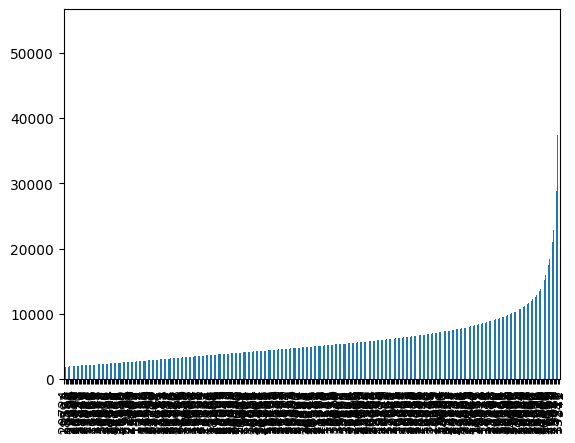

In [74]:
body_length = df["body_length"].sort_values()
# Ensuring to include the last (longest) item.
downsampled = pd.concat([body_length.iloc[::100], body_length.iloc[[-1]]]).drop_duplicates()
downsampled.plot.bar();

Calculating the bounds for body length.

In [75]:
q1 = np.percentile(df["body_length"], 25)
q3 = np.percentile(df["body_length"], 75)
iqr = q3 - q1
lower_bound_multiplier = 0.5
upper_bound_multiplier = 9
lower_bound = q1 - lower_bound_multiplier * iqr
upper_bound = q3 + upper_bound_multiplier * iqr
lower_bound, upper_bound

(np.float64(1522.5), np.float64(40005.0))

Removing the outliers based on the body length.

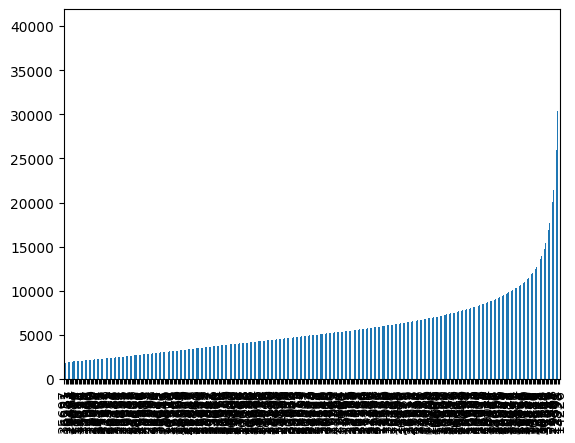

In [76]:
df = df[(df["body_length"] >= lower_bound) & (df["body_length"] <= upper_bound)]
body_length = df["body_length"].sort_values()
# Ensuring to include the last (longest) item.
downsampled = pd.concat([body_length.iloc[::100], body_length.iloc[[-1]]]).drop_duplicates()
downsampled.plot.bar();

The leaning distribution.

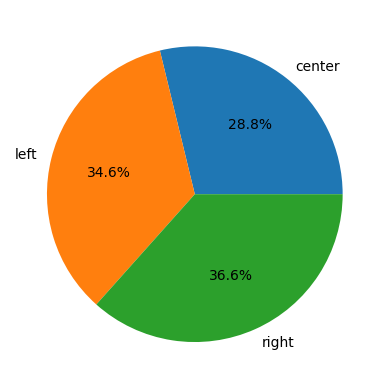

In [77]:
df.groupby("leaning", observed=True).size().plot.pie(autopct="%1.1f%%");

In [78]:
df.to_csv("../preprocessed/article_bias_prediction.csv")